In [337]:
import shutil
import importlib
import itertools
import glob, os
from os.path import *

import scipy.stats as stats
import scipy.optimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count() - 2

import copy
import niftiutils.helper_fxns as hf

In [55]:
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import util

import networks.base as nets
import datasets.common as datasets
import datasets.mnist as mnist
import datasets.cifar as cifar
import scripts.train_classifier as main
nn = torch.nn

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [410]:
importlib.reload(util)

<module 'util' from '/data/vision/polina/users/clintonw/code/vision_final/util.py'>

In [370]:
arg_list = util.get_ordered_experiments()

In [421]:
print(util.args_to_sh(arg_list[14], n_gpus=2))

nohup ./srunner.sh cls 2 --dataset fmnist --Y_fn 1+7d1 --nU 2 > cls7.out 2> cls7.err < /dev/null &


In [422]:
print(util.args_to_sh(arg_list[15], slurm=False, exc_gpu=1))

CUDA_VISIBLE_DEVICES=1,2,3 nohup python train_classifier.py --dataset fmnist --Y_fn 7+1d1 --nU 2 > cls7.out 2> cls7.err < /dev/null &


In [ ]:
python train_classifier.py --dataset mnist --img_only --epochs=3

In [ ]:
util.clean_df()

In [ ]:
[os.remove(fn) for fn in glob.glob('data/cifar100/*.npy')]

In [363]:
glob.glob('data/cifar10/*.npy')

['data/fmnist/fmnist_u5uniform_y1+1d1_n0_val.npy',
 'data/fmnist/fmnist_val.npy',
 'data/fmnist/fmnist_u5uniform_y0+1d1_n0_val.npy',
 'data/fmnist/fmnist_u5uniform_y1+1d1_n0_train.npy',
 'data/fmnist/fmnist_u5uniform_y0+1d1_n0_train.npy',
 'data/fmnist/fmnist_train.npy']

In [397]:
[os.remove(fn) for fn in glob.glob('scripts/*.err')]

[None]

In [425]:
for fn in glob.glob('scripts/*.err'):
    with open(fn, 'r') as f:
        F=f.readlines()
    if len(F)>0 and 'Error' in F[-1]:
        print(fn, F[-10:])

In [426]:
for fn in glob.glob('scripts/*.out'):
    with open(fn, 'r') as f:
        F=f.readlines()
    if len(F) < 18:
        print(fn, F[-10:])

In [ ]:
with open('scripts/cls0.err', 'r') as f:
    F=f.readlines()
F[-10:]

In [395]:
util.clean_df()

In [398]:
csv_path = '/data/vision/polina/users/clintonw/code/vision_final/results.csv'
df = pd.read_csv(csv_path, index_col=0)

In [ ]:
df

In [ ]:
df['epochs'] = -1

In [ ]:
df = df[np.concatenate([df.columns[:6], df.columns[-1:], df.columns[6:-1]])]

In [400]:
df = df.drop('fmnist_u10uniform_y1+1d1_n0_2')

In [401]:
df.to_csv(csv_path)

In [ ]:
for fn in os.listdir('history'):
    if fn[:fn.find('.')] not in df.index:
        os.remove('history/'+fn)

In [ ]:
glob.glob('history/*.hist')

In [ ]:
glob.glob('history/*.hist')

In [ ]:
glob.glob('history/*.ent')

## Deterministic analysis

In [241]:
ents = np.zeros((1000, 1000))
max_x, max_y = 0,0
for model_name, row in df.iterrows():
    ent_path = "history/%s.ent" % row['model_type']
    if not exists(ent_path):
        continue
        
    ent = hf.pickle_load(ent_path)
    x = int(ent['HU']*50)
    y = int(ent['HY_Z']*50)
    max_x = max(max_x, x)
    max_y = max(max_y, y)
    ents[x, y] = row['acc']

In [ ]:
util.heatmap(data[:max_x, :max_y].transpose(1,0), 'Sample plot', 'sample.jpg')

## etc

In [104]:
args = main.get_args('')
ent = util.get_entropy(args, nZ=10)
ents = {k:[] for k in ent}

In [84]:
d_ents = copy.deepcopy(ents)
#uni_ents = copy.deepcopy(ents)

In [95]:
args['f'](9,nU-1)

37

In [120]:
for u in range(2, 11):
    nU = round(1.5**u)
    args = main.get_args(['--Y_fn', '%d*%dd%d' % (1, 8, 1), '--nU', str(nU)])
    ent = util.get_entropy(args, nZ=10)
    for k in ent:
        ents[k].append(ent[k])

In [80]:
for nU in range(2, 20, 2):
    args = main.get_args(['--outcome_fn', 'd%d' % (nU//2), '--nU', str(nU)])
    ent = util.get_entropy(args, nZ=10)
    for k in ent:
        ents[k].append(ent[k])

In [77]:
for u in range(2, 10):
    nU = round(1.5**u)
    args = main.get_args(['--noise', str(nU//2), '--nU', str(nU)])
    ent = util.get_entropy(args, nZ=10)
    for k in ent:
        ents[k].append(ent[k])

Text(0,0.5,'HU')

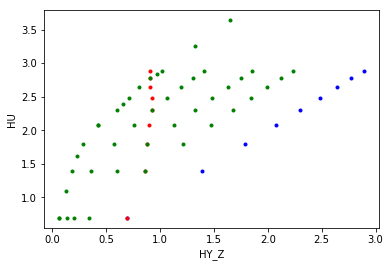

In [121]:
plt.plot(uni_ents['HY_Z'], uni_ents['HU'], 'b.')
plt.plot(d_ents['HY_Z'], d_ents['HU'], 'r.')
plt.plot(ents['HY_Z'], ents['HU'], 'g.')
plt.xlabel('HY_Z')
plt.ylabel('HU')
#plt.xlim(0,)

In [ ]:
for fn in glob.glob('history/*.ent'):
    hist_fns = glob.glob(fn[:-5]+"*.hist")
    if len(hist_fns) == 0:
        continue
    hist = hf.pickle_load(hist_fns[0])
    acc = hist['val-acc'][-1]
    ent = hf.pickle_load(fn)
    model_name = basename(hist_fns[0])[:-5]
    print(df.loc[model_name])
    df.loc[model_name, 'acc'] = acc
    desc = df.loc[model_name, 'model_type']
    ds = df.loc[model_name, 'dataset']
    xuy = np.load('data/%s/%s_val.npy' % (ds, desc))
    emp_post = util.emp_post(xuy)
    #true_post = util.true_post(xuy[:,:2], args['f'], noise=args['noise'])
    pred_post, pX, pU = util.pred_post(preds, xuy[:,:2])
    #true_KL = util.kl_div(pred_post, true_post, pX, pU)
    emp_KL = util.kl_div(pred_post, emp_post, pX, pU)
    #true_JS = util.js_div(pred_post, true_post, pX, pU)
    emp_JS = util.js_div(pred_post, emp_post, pX, pU)
    
    df.loc[model_name, 'true_KL'] = acc
    print(df.loc[model_name])
    break
    